<div style="
    padding: 20px;
    color: white;
    margin: 0;
    font-size: 300%;
    font-weight: 800;
    text-align: center;
    display: fill;
    border-radius: 60px;
    background-color: #0080FF;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
    text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5);
">
    ShoppingAppReviews 
    (EDA / Machine learning)
</div>

# <div style="display: inline-block; border: 5px solid purple; padding: 5px 10px; border-radius: 5px; font-size: 35px;"> Project. Predict ShoppingAppReviews
</div>


## Goal
> ## Interpreting data distribution plots
> ## Predicting reviews by content

# <div style="display: inline-block; padding: 20px 20px; border-radius: 15px; background: linear-gradient(135deg, #d8bfd8, #8b008b); box-shadow: 3px 3px 8px rgba(0, 0, 0, 0.2); font-size: 35px; font-family: Arial, sans-serif; color: #ffffff; text-align: center;">Import Libraries & Read Dataset</div>

In [1]:
# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import glob

# For Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
import torch
from tqdm import tqdm  

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
csv_files = glob.glob("/kaggle/input/shoppingappreviews-dataset/ShoppingAppReviews Dataset/ShoppingAppReviews/csv/*.csv")

dataframes = []

for file in csv_files:
    try:
        df = pd.read_csv(file)
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

df = pd.concat(dataframes, ignore_index=True)
df.head(5)

,reviewId,content,score,thumbsUpCount,at,replyContent,repliedAt,appName
0,275f465b-a58b-439e-ae7c-f9f6dcf2634d,Trying to use the on website is almost impossi...,1,39,1720995717000,"Hi, we are sorry to hear that. Do share additi...",1.721048e+12,Alibaba
1,e6c13852-277e-451a-b8d5-dd92aea75402,Had to uninstall due to the amount of notifica...,3,60,1720501958000,"Hi, we are sorry to hear that. Do share additi...",1.721051e+12,Alibaba
2,254b3705-c54b-4ce4-8982-5b468d38231d,I order and it takes too long the shpping days...,1,7,1721866371000,NaN,NaN,Alibaba
3,c83c1e64-6aa3-42e8-9a56-0385a297b87b,Buyer beware! They have tons of listings that ...,1,2301,1611569460000,NaN,NaN,Alibaba
4,7a65dce8-3f09-4e4e-a263-55efebc13c65,It's all around a great app except for the fac...,4,1859,1545438323000,Thanks for your feedback. Could you tell us mo...,1.515586e+12,Alibaba


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   reviewId       630000 non-null  object 
 1   content        629999 non-null  object 
 2   score          630000 non-null  int64  
 3   thumbsUpCount  630000 non-null  int64  
 4   at             630000 non-null  int64  
 5   replyContent   166488 non-null  object 
 6   repliedAt      166488 non-null  float64
 7   appName        630000 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 38.5+ MB


# <div style="display: inline-block; padding: 20px 20px; border-radius: 15px; background: linear-gradient(135deg, #d8bfd8, #8b008b); box-shadow: 3px 3px 8px rgba(0, 0, 0, 0.2); font-size: 35px; font-family: Arial, sans-serif; color: #ffffff; text-align: center;">Data Preprocessing</div>

### Because the goal of the project is to predict evaluation by looking at reviews, i removes rows that are not necessary for prediction.

In [4]:
df = df[['content','score','thumbsUpCount','appName']]

In [5]:
print("Missing Value (%)")
missing_values = df.isna().mean() * 100
print(missing_values)

print("\nDuplicate Rows (%):")
duplicate_count = df.duplicated().mean()
print(duplicate_count)

Missing Value (%)
content          0.000159
score            0.000000
thumbsUpCount    0.000000
appName          0.000000
dtype: float64

Duplicate Rows (%):
0.02159047619047619


In [6]:
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)

print("Result : Missing Value (%)")
missing_values = df.isna().mean() * 100
print(missing_values)

print("\nResult : Duplicate Rows (%):")
duplicate_count = df.duplicated().mean()
print(duplicate_count)

Result : Missing Value (%)
content          0.0
score            0.0
thumbsUpCount    0.0
appName          0.0
dtype: float64

Result : Duplicate Rows (%):
0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 616397 entries, 0 to 629999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   content        616397 non-null  object
 1   score          616397 non-null  int64 
 2   thumbsUpCount  616397 non-null  int64 
 3   appName        616397 non-null  object
dtypes: int64(2), object(2)
memory usage: 23.5+ MB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
score,616397.0,3.178315,1.795844,1.0,1.0,4.0,5.0,5.0
thumbsUpCount,616397.0,12.521923,219.228615,0.0,0.0,0.0,1.0,34774.0


In [9]:
df.describe(include='object').T

,count,unique,top,freq
content,616397,610782,Best shopping app,29
appName,616397,11,Aliexpress,124636


# <div style="display: inline-block; padding: 20px 20px; border-radius: 15px; background: linear-gradient(135deg, #d8bfd8, #8b008b); box-shadow: 3px 3px 8px rgba(0, 0, 0, 0.2); font-size: 35px; font-family: Arial, sans-serif; color: #ffffff; text-align: center;">EDA : Interpreting data distribution plots</div>

> # 1. Data distribution

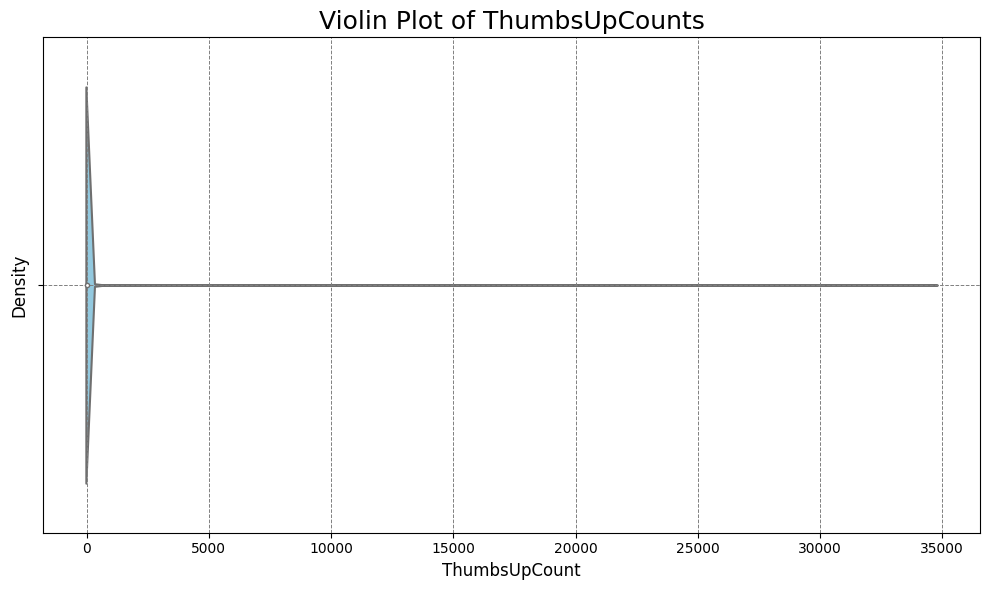

In [10]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='thumbsUpCount', color='skyblue')

plt.title('Violin Plot of ThumbsUpCounts', fontsize=18)
plt.xlabel('ThumbsUpCount', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='gray')

plt.tight_layout()
plt.show()

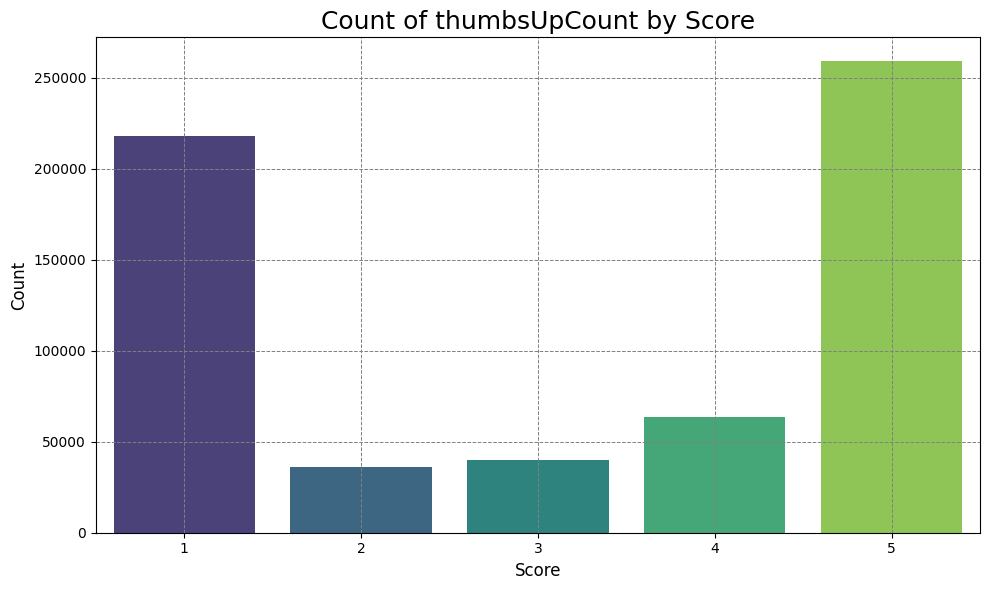

In [11]:
count_df = df.groupby('score')['thumbsUpCount'].count().reset_index(name='count')

plt.figure(figsize=(10, 6))

sns.barplot(data=count_df, x='score', y='count', palette='viridis')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='gray')
plt.xlabel('Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of thumbsUpCount by Score', fontsize=18)

plt.tight_layout()
plt.show()

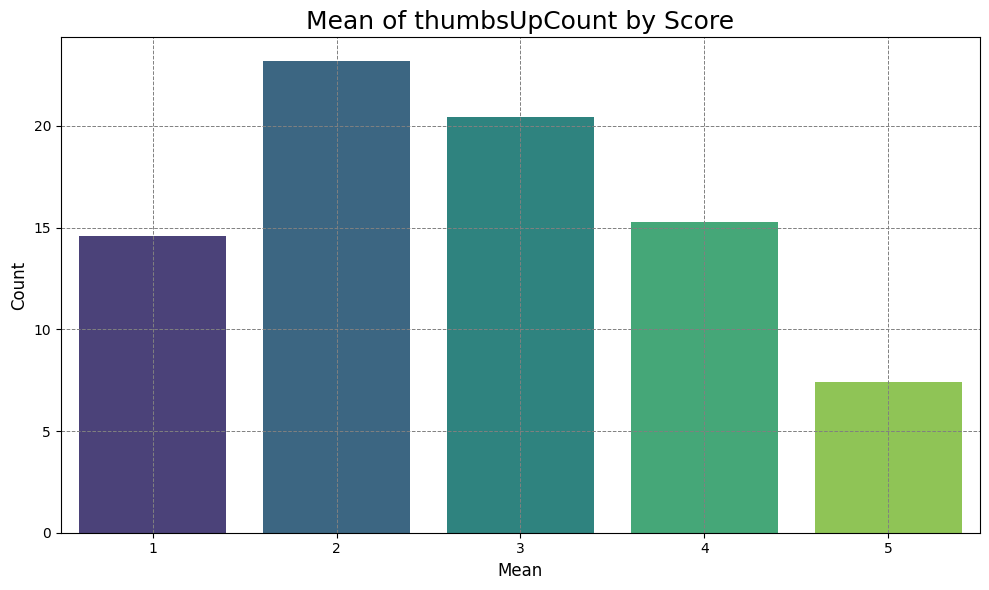

In [12]:
mean_df = df.groupby('score')['thumbsUpCount'].mean().reset_index(name='mean')

plt.figure(figsize=(10, 6))

sns.barplot(data=mean_df, x='score', y='mean', palette='viridis')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='gray')
plt.xlabel('Mean', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Mean of thumbsUpCount by Score', fontsize=18)

plt.tight_layout()
plt.show()

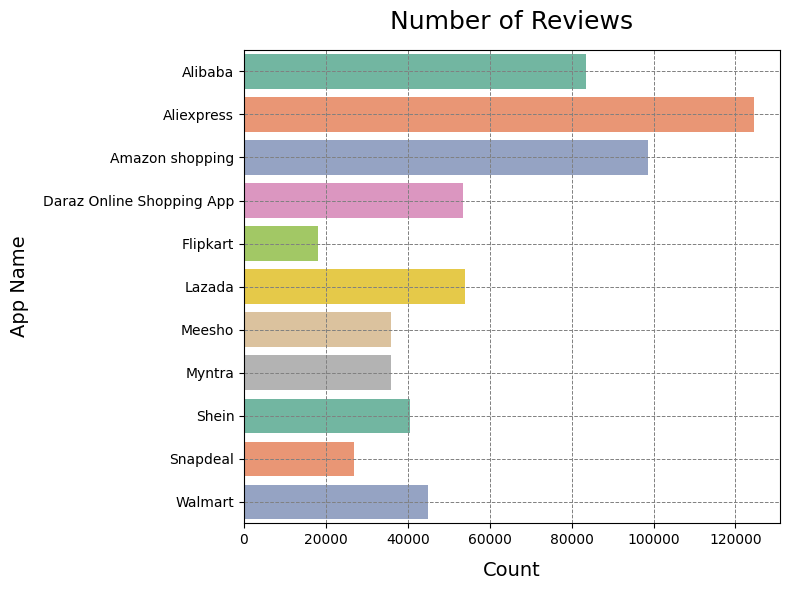

In [13]:
review_df = df.groupby('appName')['score'].count().reset_index(name='count')
plt.figure(figsize=(8, 6))
sns.barplot(data=review_df, y='appName', x='count', palette='Set2', orient='h')  

plt.title('Number of Reviews', fontsize=18, pad=15)
plt.xlabel('Count', fontsize=14, labelpad=10)
plt.ylabel('App Name', fontsize=14, labelpad=10)

plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='gray')

plt.tight_layout()
plt.show()

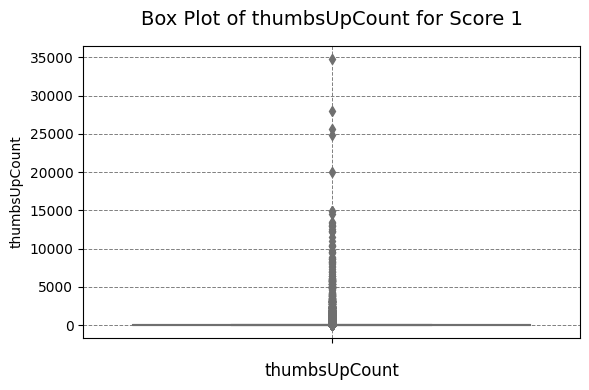

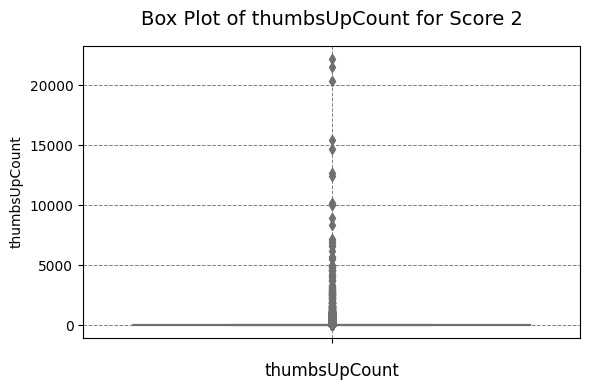

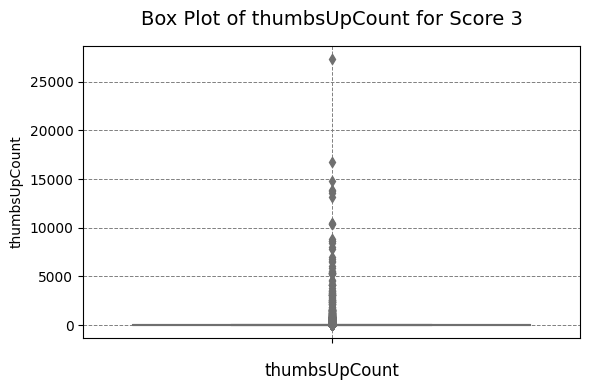

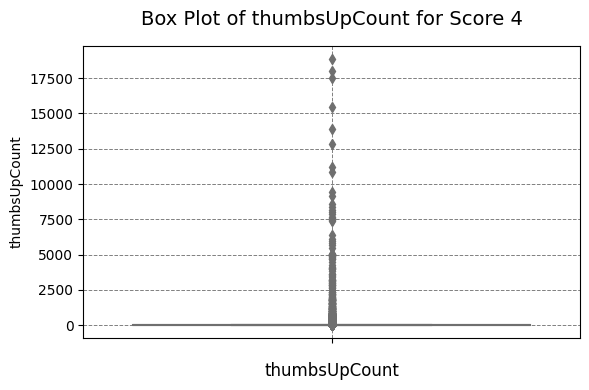

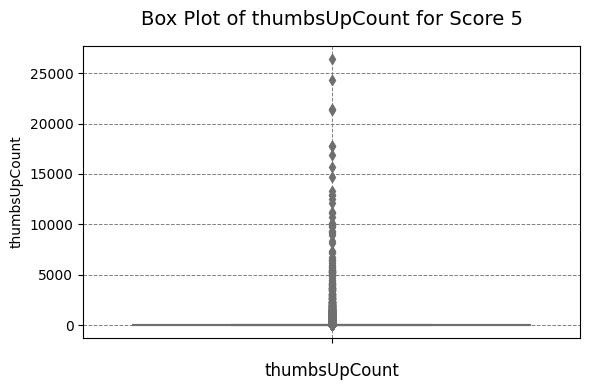

In [14]:
score_groups = df.groupby('score')['thumbsUpCount']

for score, group in score_groups:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=group, color='skyblue')
    plt.title(f"Box Plot of thumbsUpCount for Score {score}", fontsize=14, pad=15)
    plt.xlabel('thumbsUpCount', fontsize=12, labelpad=10)
    plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='gray')
    plt.tight_layout()
    plt.show()

> # 2. Evaluation distribution

In [15]:
def classify_review(score):
    if score in [1,2]:
        return 'bad'
    elif score == 3:
        return 'normal'
    elif score in [4,5]:
        return 'good'

df['review'] = df['score'].apply(classify_review)
df['review'].unique()

array(['bad', 'normal', 'good'], dtype=object)

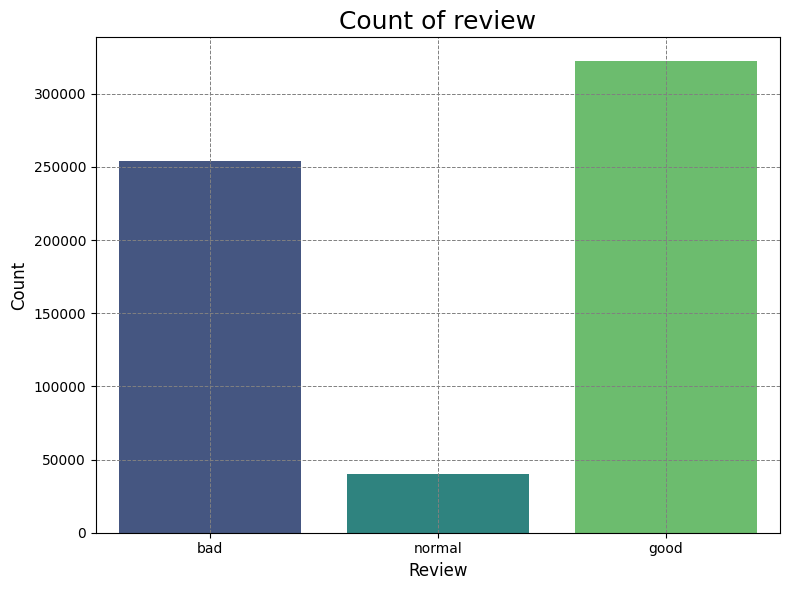

In [16]:
review_order = ['bad', 'normal', 'good']
df['review'] = pd.Categorical(df['review'], categories=review_order, ordered=True)

review_counts = df['review'].value_counts().reindex(review_order)

plt.figure(figsize=(8, 6))
sns.barplot(x=review_counts.index, y=review_counts.values, palette='viridis')
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='gray')
plt.xlabel('Review', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of review', fontsize=18)

plt.tight_layout()
plt.show()

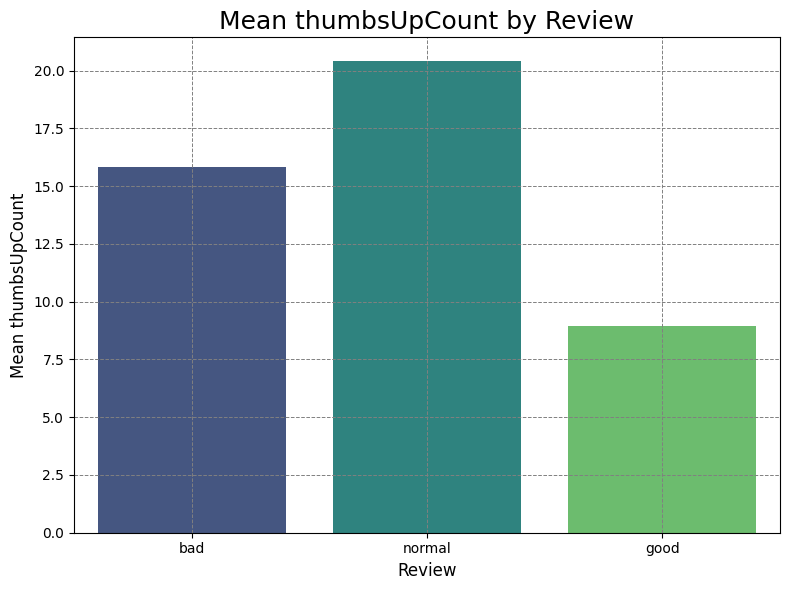

In [17]:
mean_df = df.groupby('review')['thumbsUpCount'].mean().reset_index(name='mean')


plt.figure(figsize=(8, 6))
sns.barplot(x=mean_df['review'], y=mean_df['mean'], palette='viridis')

plt.grid(visible=True, which='major', linestyle='--', linewidth=0.7, color='gray')
plt.xlabel('Review', fontsize=12)
plt.ylabel('Mean thumbsUpCount', fontsize=12)
plt.title('Mean thumbsUpCount by Review', fontsize=18)

plt.tight_layout()
plt.show()

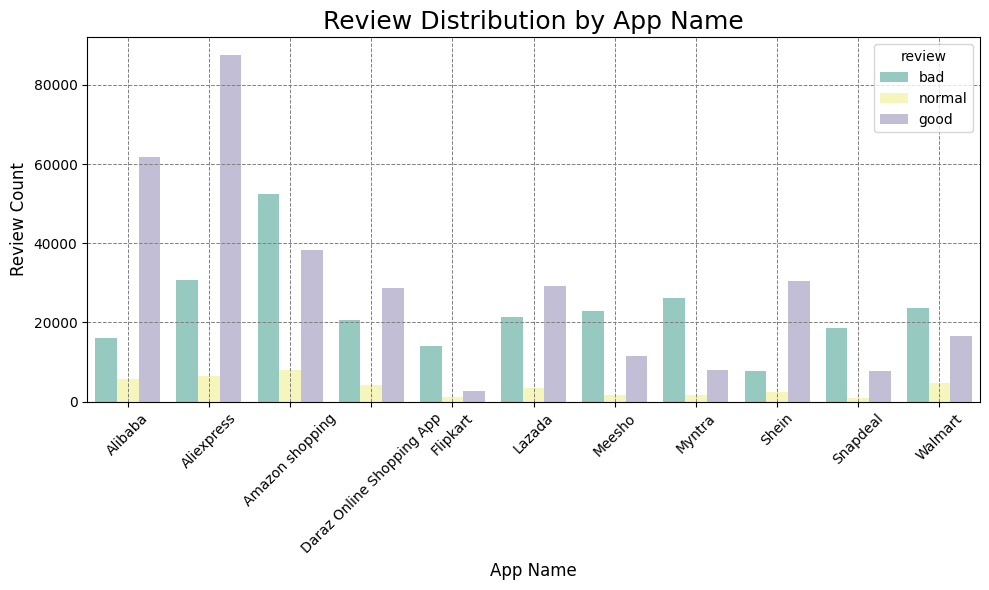

In [18]:
review_counts = df.groupby(['appName', 'review']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=review_counts, x='appName', y='count', hue='review', palette='Set3')

plt.xlabel('App Name', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.title('Review Distribution by App Name', fontsize=18)
plt.xticks(rotation=45) 
plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray') # 그리드 설정

plt.tight_layout()
plt.show()

# <div style="display: inline-block; padding: 20px 20px; border-radius: 15px; background: linear-gradient(135deg, #d8bfd8, #8b008b); box-shadow: 3px 3px 8px rgba(0, 0, 0, 0.2); font-size: 35px; font-family: Arial, sans-serif; color: #ffffff; text-align: center;">Modeling : Predicting reviews by content</div>

> # 0. BERT Embedding

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def embed_texts(texts, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

X = embed_texts(df['content'].tolist())
y = df['review']

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 38525/38525 [56:19<00:00, 11.40it/s]


> # 1. Compare Machine learning model

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import catboost as cb


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


models = {
    "Random Forest": RandomForestClassifier(),
#    "SVC": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
#    "Gradient Boosting": GradientBoostingClassifier(),
#    "CatBoost": cb.CatBoostClassifier(verbose=0)
}


results = []

for name, model in models.items():
    if name in ["XGBoost", "CatBoost"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif name == "Naive Bayes":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results.append([name, accuracy])


results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])
results_df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.314370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 493117, number of used features: 768
[LightGBM] [Info] Start training from score -0.886187
[LightGBM] [Info] Start training from score -0.647814
[LightGBM] [Info] Start training from score -2.739740


,Model,Accuracy
0,Random Forest,0.846439
1,Logistic Regression,0.862857
2,Naive Bayes,0.681489
3,XGBoost,0.859231
4,LightGBM,0.855638


> # 2. BERT (BertForSequenceClassification)

In [21]:
'''
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextDataset(X_train.tolist(), y_train, tokenizer)
val_dataset = TextDataset(X_test.tolist(), y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Training Loss = {train_loss / len(train_loader)}")
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Validation Loss = {val_loss / len(val_loader)}")
'''

'\nfrom transformers import BertForSequenceClassification, AdamW\nfrom torch.utils.data import DataLoader, Dataset\n\nmodel = BertModel.from_pretrained(\'bert-base-uncased\')\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel.to(device)\n\n\nclass TextDataset(Dataset):\n    def __init__(self, texts, labels, tokenizer, max_length=512):\n        self.texts = texts\n        self.labels = labels\n        self.tokenizer = tokenizer\n        self.max_length = max_length\n\n    def __len__(self):\n        return len(self.texts)\n\n    def __getitem__(self, idx):\n        text = self.texts[idx]\n        label = self.labels[idx]\n        inputs = self.tokenizer(text, truncation=True, padding=\'max_length\', max_length=self.max_length, return_tensors=\'pt\')\n        return {\n            \'input_ids\': inputs[\'input_ids\'].squeeze(0),\n            \'attention_mask\': inputs[\'attention_mask\'].squeeze(0),\n            \'labels\': torch.tensor(label, dtype=torch.l

In [22]:
'''
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))
'''

'\nmodel.eval()\npredictions = []\ntrue_labels = []\n\nwith torch.no_grad():\n    for batch in val_loader:\n        input_ids = batch[\'input_ids\'].to(device)\n        attention_mask = batch[\'attention_mask\'].to(device)\n        labels = batch[\'labels\'].to(device)\n        outputs = model(input_ids, attention_mask=attention_mask)\n        logits = outputs.logits\n        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())\n        true_labels.extend(labels.cpu().numpy())\n\nprint("Classification Report:")\nprint(classification_report(true_labels, predictions, target_names=label_encoder.classes_))\n'

In [23]:
'''
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
'''

"\nfrom sklearn.metrics import confusion_matrix\n\ncm = confusion_matrix(y_true, y_pred)\n\nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)\nplt.title('Confusion Matrix')\nplt.xlabel('Predicted Labels')\nplt.ylabel('True Labels')\nplt.show()\n"

# <div style="display: inline-block; padding: 20px 20px; border-radius: 15px; background: linear-gradient(135deg, #d8bfd8, #8b008b); box-shadow: 3px 3px 8px rgba(0, 0, 0, 0.2); font-size: 35px; font-family: Arial, sans-serif; color: #ffffff; text-align: center;">Utilize the model</div>

In [24]:
'''
new_texts = ["It's a really good product!", "It was a terrible experience"]

new_embeddings = embed_texts(new_texts)

model.eval()
with torch.no_grad():
    inputs = torch.tensor(new_embeddings, dtype=torch.float32).to(device)
    outputs = model(inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

predicted_labels = label_encoder.inverse_transform(predictions.cpu().numpy())
print(predicted_labels)
'''

'\nnew_texts = ["It\'s a really good product!", "It was a terrible experience"]\n\nnew_embeddings = embed_texts(new_texts)\n\nmodel.eval()\nwith torch.no_grad():\n    inputs = torch.tensor(new_embeddings, dtype=torch.float32).to(device)\n    outputs = model(inputs)\n    predictions = torch.argmax(outputs.logits, dim=-1)\n\npredicted_labels = label_encoder.inverse_transform(predictions.cpu().numpy())\nprint(predicted_labels)\n'

# <div style="display: inline-block; padding: 20px 20px; border-radius: 15px; background: linear-gradient(135deg, #d8bfd8, #8b008b); box-shadow: 3px 3px 8px rgba(0, 0, 0, 0.2); font-size: 35px; font-family: Arial, sans-serif; color: #ffffff; text-align: center;">Thanks !</div>

### There is an error in the BERT model code because i did not do the BERT test due to time and resource issues (I'll fix it when I have time !). If you have any questions, please feel free to ask me a question and use the code freely